# Fit S(Q)

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# Fit the I(Q) curve using the S(Q) generated by pre-trained cVAE model
# Infer potential parameters from optimized latent variables using GPR
# tensorflow 2.10.0
# sklearn 0.24.2

## Setup

In [2]:
fit_SQ = 0

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

from scipy.io import savemat

import tensorflow as tf
print(tf. __version__)

2.10.0


## Load data

In [4]:
W = 10

In [5]:
import os
data_path = './fwdexternalsilica/'
filename_0 = '{}_600.dat'.format(W)
filename_1 = '{}_1100.dat'.format(W)
print(filename_0)
data_0 = np.genfromtxt(data_path + filename_0, skip_header=39, delimiter=[11,15,12,10])
data_1 = np.genfromtxt(data_path + filename_1, skip_header=39, delimiter=[11,15,12,10])
data_p = np.genfromtxt(data_path + '168606_d01_c01.dat', skip_header=39, delimiter=[11,14,11,10])

10_600.dat


In [6]:
Q_0 = data_0[:,0]
IQ_data_0 = data_0[:,1]
IQ_er_0 = data_0[:,2]
dQ_0 = data_0[:,3]

Q_1 = data_1[:,0]
IQ_data_1 = data_1[:,1]
IQ_er_1 = data_1[:,2]
dQ_1 = data_1[:,3]

Q_p = data_p[:,0]
IQ_data_p = data_p[:,1]
IQ_er_p = data_p[:,2]
dQ_p = data_p[:,3]

In [7]:
# load desmeared data
filename_0 = '{}_600_d.txt'.format(W)
filename_1 = '{}_1100_d.txt'.format(W)
filename_p = 'dilute.txt'
print(filename_0)

data_0 = np.genfromtxt(data_path + filename_0, skip_header=0, delimiter=[16,16,16])
data_1 = np.genfromtxt(data_path + filename_1, skip_header=0, delimiter=[16,16,16])
data_p = np.genfromtxt(data_path + filename_p, skip_header=0, delimiter=[16,16,16])

Q_0_d = data_0[:,0]
IQ_data_0_d = data_0[:,1]
IQ_er_0_d = data_0[:,2]

Q_1_d = data_1[:,0]
IQ_data_1_d = data_1[:,1]
IQ_er_1_d = data_1[:,2]

Q_p_d = data_p[:,0]
IQ_data_p_d = data_p[:,1]
IQ_er_p_d = data_p[:,2]

10_600_d.txt


Fit P(Q) to obtain the HS diameter

In [71]:
# fit P(Q)
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def fuzzysphere(q,sigma=1,sigma_f=0.1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2*np.exp(-(sigma_f*sigma*q)**2/2)
    return P

def log_normal_pdf(mu,sigma,x):
    return np.exp(-(np.log(x)-mu)**2/2/sigma**2)/x/sigma

def P_HS_eff(q,sigma=1,d_sigma=0.05):
    n_sample = 141
    sigma_list = (1+np.linspace(-7,7,n_sample)*d_sigma)*sigma
    # p_sigma = np.exp(np.linspace(-3,3,n_sample)**2/2)*(sigma_list)**6
    p_sigma = log_normal_pdf(0,d_sigma,sigma_list/sigma)*(sigma_list)**6
    # var = d_sigma**2
    # k = 1/var
    # x = (1+np.linspace(-3,3,n_sample)*d_sigma)
    # p_sigma = k**k*x**(k-1)*np.exp(-k*x)/gamma(k)

    P_eff = np.zeros_like(q)

    for i in range(n_sample):
        P_i = hardsphere(q,sigma_list[i])*p_sigma[i]
        P_eff = P_eff + P_i

    P_eff = P_eff/np.sum(p_sigma)

    return P_eff

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out # sampled on Q

def I_P(Q, sigma, A, I_inc, d_sigma):
    P = P_HS_eff(Q_p,sigma=sigma,d_sigma=d_sigma)
    Q_fine = Q_p
    P_res = IQ_resoln(Q_p,Q_fine,P,dQ_p*1.0)
    f_interp = interp.interp1d(Q_fine,P_res,fill_value='extrapolate')
    P = f_interp(Q)

    return A*P + I_inc

def I_P_d(Q, sigma, A, I_inc, d_sigma):
    # desmeared
    P = P_HS_eff(Q,sigma=sigma,d_sigma=d_sigma)
    # Q_fine = Q
    # P_res = IQ_resoln(Q_p,Q_fine,P,dQ_p*1.0)
    # f_interp = interp.interp1d(Q_fine,P_res,fill_value='extrapolate')
    # P = f_interp(Q)

    return A*P + I_inc

# loss function for fitting form factor
def lambda_P(fp):
    sigma = fp[0] 
    A = fp[1] 
    I_inc = fp[2]
    d_sigma = fp[3]
    index_Q = (Q_p_d>1e-5)*(Q_p_d<3e-1)
    return np.sum((np.log(I_P_d(Q_p_d, sigma, A, I_inc, d_sigma)) - np.log(IQ_data_p_d))[index_Q]**2)

# loss function for extracting incoherent background using the dilute form factor
def lambda_IP(Q,IQ,fp,index_q=[]):
    sigma = fp[0] 
    A = fp[1] 
    I_inc = fp[2]
    d_sigma = fp[3]
    # index_Q = (Q>2e-2)*(Q<3e-1)
    return np.sum((np.log(I_P(Q,sigma, A, I_inc, d_sigma)) - np.log(IQ))[index_Q]**2)
    

In [76]:
Q_min_0 = 1e-2
# sigma_0 = 4.5*2/Q_min_0
sigma_0 = 1100
A_0 = 2.2e3
I_inc_0 = 1.5
d_sigma_0 = 0.025
x0 = [sigma_0, A_0, I_inc_0, d_sigma_0]
lb = [sigma_0*0.5, A_0*0.9, I_inc_0*0.09, d_sigma_0*0.5]
ub = [sigma_0*1.5, A_0*1.1, I_inc_0*1.01, d_sigma_0*2]
x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))
opti_P = opt.minimize(lambda_P, x0=np.array(x0), bounds = x_bounds,
                      method='L-BFGS-B',
                      jac='3-point',
                      options={'maxiter':1000,'ftol':1e-15, 'gtol':1e-15},
                      )
fp_opt_P = opti_P.x.copy()
opti_P

      fun: 4.576243096533743
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.74709164e-11, -8.55116089e-04,  7.23146909e-09, -5.79401632e+01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 432
      nit: 44
     njev: 48
   status: 0
  success: True
        x: array([1.19332257e+03, 2.42000000e+03, 1.16625840e+00, 5.00000000e-02])

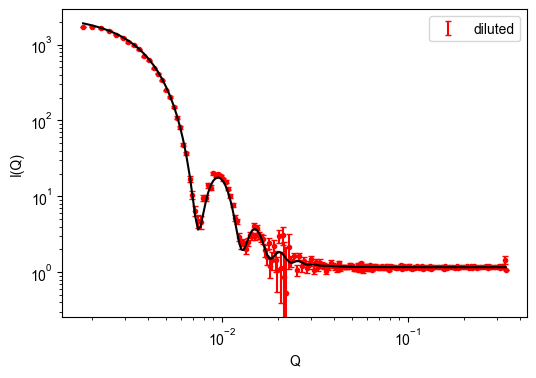

In [77]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q_p_d,IQ_data_p_d,'.r')
ax.errorbar(Q_p_d,IQ_data_p_d,IQ_er_p_d,linestyle='',label='diluted',color='r',capsize=2)
# ax.plot(Q_p,IQ_data_p,'.m',label='diluted')
ax.plot(Q_p_d,I_P_d(Q_p_d, fp_opt_P[0],fp_opt_P[1],fp_opt_P[2],fp_opt_P[3]),'-k',zorder=3)
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

Fit I(Q) to obtain the intensity

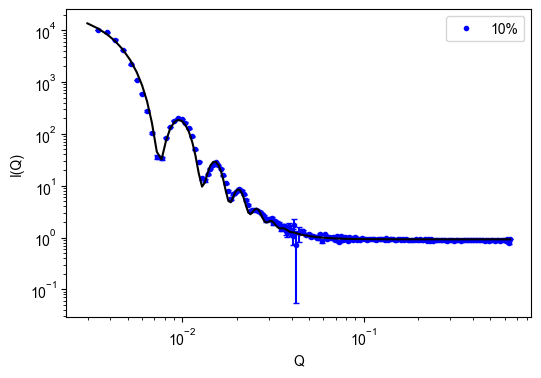

In [78]:
# segment_0
Q_min_0 = 1e-2
# sigma_0 = 4.5*2/Q_min_0
sigma = fp_opt_P[0]
A_0 = 4e4
I_inc_0 = 1.35
d_sigma = fp_opt_P[3]
x0 = [A_0, I_inc_0]
lb = [A_0*0.5, I_inc_0*0.05]
ub = [A_0*1.5, I_inc_0*1.05]
index_Q = (Q_0_d>7e-3)*(Q_0_d<3e-1)
fun = lambda x: lambda_IP(Q_0_d, IQ_data_0_d, [sigma, x[0], x[1], d_sigma], index_Q)
x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))
opti_I_0 = opt.minimize(fun, x0=np.array(x0), bounds = x_bounds,
                      method='L-BFGS-B',
                      jac='3-point',
                      options={'maxiter':1000,'ftol':1e-12, 'gtol':1e-12},
                      )
fp_opt_I_0 = opti_I_0.x

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q_0_d,IQ_data_0_d,'.b',label='{}%'.format(W))
ax.errorbar(Q_0_d,IQ_data_0_d,IQ_er_0_d,linestyle='',color='b',capsize=2)
ax.plot(Q_0,I_P_d(Q_0, fp_opt_P[0],fp_opt_I_0[0],fp_opt_I_0[1],fp_opt_P[3]),'-k')
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

In [79]:
opti_I_0

      fun: 3.9164314271079053
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.42854148e-11,  1.10005586e-09])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 165
      nit: 25
     njev: 33
   status: 0
  success: True
        x: array([2.69846156e+04, 9.22103916e-01])

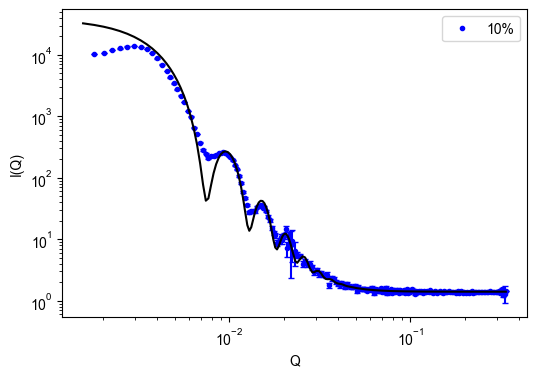

In [80]:
# segment_1
Q_min_0 = 1e-2
# sigma_0 = 4.5*2/Q_min_0
sigma = fp_opt_P[0]
A_0 = 5e4
I_inc_0 = 1.8
d_sigma = fp_opt_P[3]
x0 = [A_0, I_inc_0]
lb = [A_0*0.5, I_inc_0*0.05]
ub = [A_0*1.5, I_inc_0*1.05]
index_Q = (Q_0_d>7e-3)*(Q_0_d<3e-1)
fun = lambda x: lambda_IP(Q_1_d, IQ_data_1_d, [sigma, x[0], x[1], d_sigma], index_Q)
x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))
opti_I_1 = opt.minimize(fun, x0=np.array(x0), bounds = x_bounds,
                      method='L-BFGS-B',
                      jac='3-point',
                      options={'maxiter':1000,'ftol':1e-12, 'gtol':1e-12},
                      )
fp_opt_I_1 = opti_I_1.x

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q_1_d,IQ_data_1_d,'.b',label='{}%'.format(W))
ax.errorbar(Q_1_d,IQ_data_1_d,IQ_er_1_d,linestyle='',color='b',capsize=2)
ax.plot(Q_1,I_P_d(Q_1, fp_opt_P[0],fp_opt_I_1[0],fp_opt_I_1[1],fp_opt_P[3]),'-k')
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

In [81]:
opti_I_1

      fun: 3.8764789605674626
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.59213688e-11,  1.54651719e-08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 165
      nit: 29
     njev: 33
   status: 0
  success: True
        x: array([3.90214339e+04, 1.40128416e+00])

### Joining the curves


In [82]:
# IQ_0 = (IQ_data_0_d-fp_opt_I_0[1])/fp_opt_I_0[0]
# IQ_1 = (IQ_data_1_d-fp_opt_I_1[1])/fp_opt_I_1[0]
# IQ_er_0 = (IQ_er_0_d)/fp_opt_I_0[0]
# IQ_er_1 = (IQ_er_1_d)/fp_opt_I_1[0]

# Q_scan_list = np.linspace(1e-3,2e-1,1000)
# Q_scan = []
# IQ_scan = []
# i_Qc_0 = 0
# i_Qc_1 = 0
# for Q in Q_scan_list:
#     update_0=0
#     update_1=0
#     if Q>Q_0_d[i_Qc_0]:
#         i_Qc_0 += 1
#         update_0=1
#     if Q>Q_1_d[i_Qc_1]:
#         i_Qc_1 += 1
#         update_1=1
#     if update_0+update_1==0:
#         continue

#     IQc_0 = IQ_0[i_Qc_0]
#     IQc_1 = IQ_1[i_Qc_1]

#     i_smaller = 0
#     if IQc_1<IQc_0:
#         i_smaller = 1

#     Qc = [Q_0_d[i_Qc_0],Q_1_d[i_Qc_1]]
#     IQc = [IQc_0,IQc_1]

#     Q_scan.append(Qc[i_smaller])
#     IQ_scan.append(IQc[i_smaller])

# Q_scan = np.array(Q_scan)
# IQ_scan = np.array(IQ_scan)

C:\Users\CHTUNG\AppData\Local\Temp\ipykernel_32492\1394202138.py:30: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0,0.04])


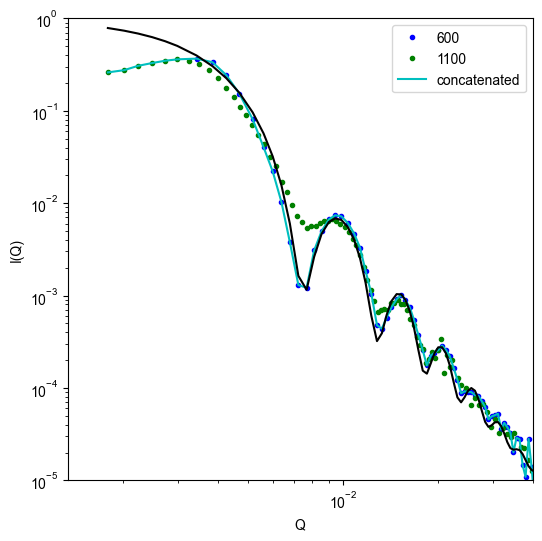

In [83]:
IQ_0 = (IQ_data_0_d-fp_opt_I_0[1])/fp_opt_I_0[0]
IQ_1 = (IQ_data_1_d-fp_opt_I_1[1])/fp_opt_I_1[0]
IQ_er_0 = (IQ_er_0_d)/fp_opt_I_0[0]
IQ_er_1 = (IQ_er_1_d)/fp_opt_I_1[0]

Q_switch = 3e-3
index_cat_0 = Q_0_d>Q_switch
index_cat_1 = Q_1_d<Q_switch
Q_cat_0 = Q_0_d[index_cat_0]
Q_cat_1 = Q_1_d[index_cat_1]
IQ_cat_0 = IQ_0[index_cat_0]
IQ_cat_1 = IQ_1[index_cat_1]
IQ_er_cat_0 = IQ_er_0[index_cat_0]
IQ_er_cat_1 = IQ_er_1[index_cat_1]

Q_cat = np.r_[Q_cat_1,Q_cat_0]
IQ_cat = np.r_[IQ_cat_1,IQ_cat_0]
IQ_er_cat = np.r_[IQ_er_cat_1,IQ_er_cat_0]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(Q_0_d,IQ_0,'.b',label='600')
ax.plot(Q_1_d,IQ_1,'.g',label='1100')
ax.plot(Q_cat,IQ_cat,'-c',label='concatenated')
ax.plot(Q_cat, I_P_d(Q_cat, fp_opt_P[0],1,0,fp_opt_P[3]),'-k')
# ax.errorbar(Q_cat,IQ_cat,IQ_er_cat,linestyle='',color='k',capsize=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0,0.04])
ax.set_ylim([1e-5,1])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

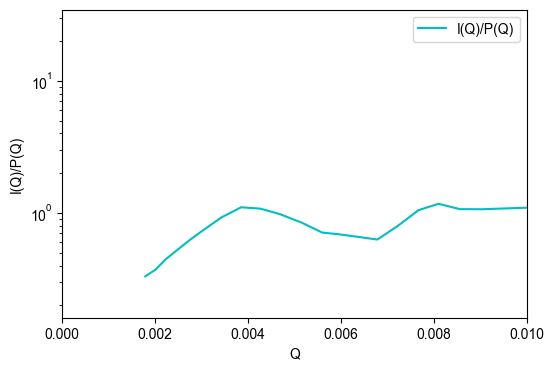

In [84]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
# ax.plot(Q_1,IQ_data_1,'.r')
# ax.plot(Q_1,I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]),'-k')
ax.plot(Q_cat,IQ_cat/I_P_d(Q_cat, fp_opt_P[0],1,0,fp_opt_P[3]),'-c',label = 'I(Q)/P(Q)')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([0,0.01])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)/P(Q)')
ax.legend()
plt.show()

In [85]:
# save form factor fitting
fp = fp_opt_P
fp[1] = fp_opt_I_0[0]
fp[2] = fp_opt_I_0[1]

mdic = {'fp':fp}
filename = './results/Fit_P_W_{}.mat'.format(W)

savemat(filename, mdic)


In [86]:
## convert the input data to the same 80-D array as SQ-NN model
sq_dim = 80
sample_dim = 1

### Rescale

In [87]:
## rescale the input data Q range
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2

'''
The input data is rescaled to the range such that 0.02<=QD<=16 
'''
r_HS_i = fp_opt_P[0]/2 # initial guess of r_HS when Q = 0.04112146, Qr_HS = 3 (first peak)
d_HS_i = r_HS_i*2
print('Initial guess of d_HS = {}'.format(d_HS_i))
IQ_rs = np.zeros((sample_dim,sq_dim)) 
Qd_HS = Q_cat*d_HS_i

## rescale IQ to QD in [0,16]
f_IQ = interp.interp1d(Qd_HS,IQ_cat,fill_value='extrapolate')
IQ_rs = f_IQ(q_rs).astype(np.float32)
IQ_rs[IQ_rs<=0] = 1e-5

## rescale IQ_er to QD in [0,16]
f_IQ_er = interp.interp1d(Qd_HS,IQ_er_cat,fill_value='extrapolate')
IQ_er_rs = f_IQ_er(q_rs).astype(np.float32)
IQ_er_rs[IQ_er_rs<=0] = 1e-5

# ## rescale IQ_er to QD in [0,16]
# f_IQ_er = interp.interp1d(Qd_HS[0:],IQ_er_1[0:],fill_value='extrapolate')
# IQ_er_rs = f_IQ_er(q_rs).astype(np.float32)

Initial guess of d_HS = 1193.3225704510226


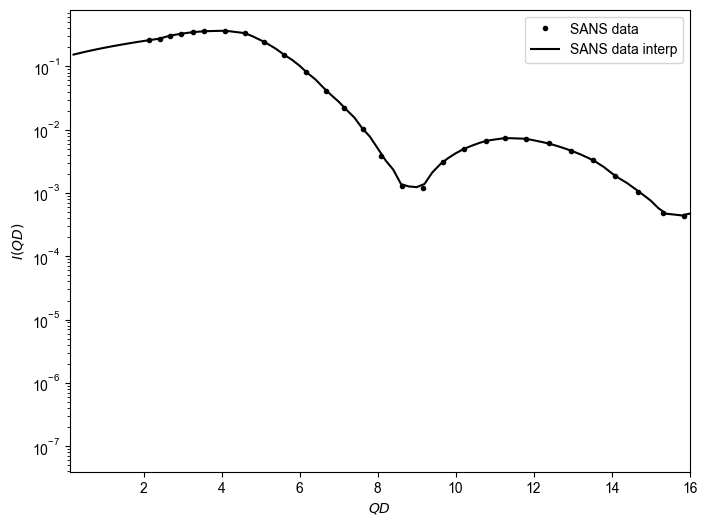

In [88]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(Qd_HS,IQ_cat,'.k',label='SANS data')
ax.plot(q_rs,IQ_rs,'-k',label='SANS data interp')
ax.set_xlim([0.1,16])
# ax.set_ylim([0.1,30])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')
ax.legend()
plt.show()

### Resolution

In [89]:
# interpolating_function_dQ = interp.interp1d(Qd_HS,dQ_1*1*d_HS_i,fill_value='extrapolate',kind= 'linear')
# dQ_interp = interpolating_function_dQ(q).astype(np.float32)
# dQ_sm = sgnl.savgol_filter(dQ_interp,5,3)

# fig = plt.figure(figsize=(8, 6))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q,dQ_sm,'.k',label='SANS data')
# # ax.set_xlim([0,16])
# # ax.set_ylim([5,2000])
# ax.set_yscale('log')
# ax.set_xlabel(r'$QD$')
# ax.set_ylabel(r'$R(QD)$')
# ax.legend()
# plt.show()

## Define functions 

In [90]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug, sm_GP
SQ_NN_GP = lambda x: SQ_NN(x,GP=True,lmbda=1)

In [91]:
def SQ_th(sq_func,fp):
    # structure factor
    return sq_func(fp[0:3])

def scale(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def IQ_th(sq_func,fp):
    # form factor
    r_sigma = fp[3]
    P = P_HS_eff(q,sigma=r_sigma, d_sigma=fp_opt_P[3])

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P#*fp_opt_I[0] + fp_opt_I[1]

    # # resolution
    # dQ = dQ_sm
    # Q_fine = np.linspace(0.2,16,1000)

    # f_interp = interp.interp1d(q,IQ)
    # IQ_Qfine = f_interp(Q_fine)
    # IQ_res = IQ_resoln(q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(q,IQ,r_sigma) 
    f_interp = interp.interp1d(q,IQ_res_scale)
    # I_scale(QD) = I(QD/fp[3]), 
    # if I_scale(QD) = I^(QD*), D*=D/fp[3], D = D*fp[3]
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp

def IQ_th_res(sq_func,fp):
    # form factor
    r_sigma = fp[3]
    P = P_HS_eff(q,sigma=r_sigma, d_sigma=fp_opt_P[3])

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P#*fp_opt_I[0] + fp_opt_I[1]

    # resolution
    dQ = dQ_sm
    Q_fine = np.linspace(0.2,16,1000)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(q,IQ_res,r_sigma) 
    f_interp = interp.interp1d(q,IQ_res_scale)
    # I_scale(QD) = I(QD/fp[3]), 
    # if I_scale(QD) = I^(QD*), D*=D/fp[3], D = D*fp[3]
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp

## Pick an I(Q) and test

In [92]:
IQ_exp = IQ_rs

### Initial value

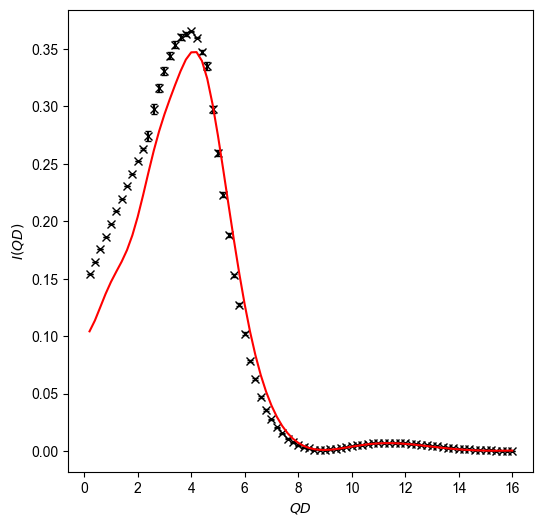

In [100]:
fp_i =       [0.16,  0.3,   1.5,  1]
fp_ubounds = (0.2,  0.5,   20,  1.1)
fp_lbounds = (0.05, 0.05,  0.5, 0.9)
fp_bounds_opt = opt.Bounds(lb=np.array(fp_lbounds), ub=np.array(fp_ubounds))
fp = fp_i

# plot initial parameters
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

# ax.errorbar(q,IQ_rs,yerr=IQ_er_rs,fmt='k')
ax.plot(q,IQ_rs,'xk')
ax.errorbar(q,IQ_rs,IQ_er_rs,color='k',capsize=2,linestyle='')
ax.plot(q,IQ_th(SQ_NN_GP,fp_i),'-r')

ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')

# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

In [101]:
def Fit_loss(sq_func,fp):
    scale=1
    IQ_NN = IQ_th(sq_func,fp)
    f_loss = scale*((IQ_exp)-(IQ_NN))[(q>=0)&(q<=16)]
    f_loss[IQ_NN<=0] = 0
    return f_loss

def func_IQ_NN_err(fp):
    return np.mean((Fit_loss(SQ_NN_GP,fp))**2)

def func_minimize(func, fp_fix, fp_x0, index_x, callback=False):
    '''
    func: regression loss to be minimized
    fp_fix: fixed parameters
    fp_x0: initial guess
    index_x: index of free fitting parameters
    
    '''
    index_fixed = np.array([x for x in np.arange(len(fp_fix)) if not x in index_x])

    def f(x,args):
        fp = fp_fix
        for i, index in enumerate(index_x):
            fp[index] = x[i]
        return func(fp)

    x_bounds = opt.Bounds(lb=np.array(fp_lbounds)[index_x], ub=np.array(fp_ubounds)[index_x])

    if len(index_fixed)==0:
        args_fixed = None
    else:
        args_fixed = np.array(fp_fix)[index_fixed]
    
    f_callback = None
    if callback:
        fp_history = []
        def f_callback(x):
            fp = fp_fix
            for i, index in enumerate(index_x):
                fp[index] = x[i]
            fp_history.append(x)
    
    opti = opt.minimize(f, x0=np.array(fp_x0)[index_x], args=args_fixed, 
                        method='L-BFGS-B',bounds=x_bounds,
                        jac='3-point',
                        options={'maxiter':2000,'ftol':1e-15, 'gtol':1e-15},
                        callback=f_callback
                        )
    
    if callback:
        return opti, fp_history
    else:
        return opti
    
def fit_err(opti, index_x, IQ_MSE=0.01):
    fp_opt = fp_i
    for i, index in enumerate(index_x):
        fp_opt[index] = opti.x[i]
        
    # https://stackoverflow.com/questions/43593592
    fp_opt_err = np.zeros(len(fp_opt))
    tmp_i = np.zeros(len(opti.x))
    for i, index in enumerate(index_x):
        tmp_i[i] = 1.0
        hess_inv_i = opti.hess_inv(tmp_i)[i]
        uncertainty_i = np.sqrt(max(1, abs(opti.fun)) * IQ_MSE * hess_inv_i)
        tmp_i[i] = 0.0
        fp_opt_err[index] = uncertainty_i
        print(hess_inv_i)
        
    return fp_opt, fp_opt_err

In [102]:
index_free=np.arange(3)
opti_NN, fp_history = func_minimize(func_IQ_NN_err, fp_fix=fp_i.copy(), fp_x0=fp_i.copy(), index_x=index_free, callback=True)

fp_opt_NN = fp_i.copy()
for i, index in enumerate(index_free):
    fp_opt_NN[index] = opti_NN.x[i]

In [103]:
fp_opt_NN, fp_err_NN = fit_err(opti_NN, index_free, IQ_MSE=0.01**2)

0.6182584360013813
34.96036524953982
13.441470912806754


In [104]:
opti_NN

      fun: 5.5069978191228936e-05
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.13345412e-05, -5.76418458e-06,  1.83528831e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 266
      nit: 15
     njev: 38
   status: 0
  success: True
        x: array([0.13744255, 0.23346842, 1.4952561 ])

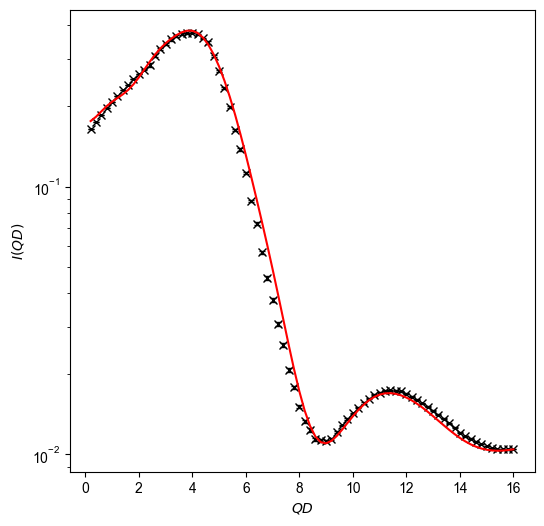

In [116]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

I_inc = 1e-2

# ax.errorbar(q,IQ_rs,yerr=IQ_er_rs,fmt='k')
ax.plot(q,IQ_rs+I_inc,'xk')
ax.errorbar(q,IQ_rs+I_inc,IQ_er_rs,color='k',capsize=2,linestyle='')
ax.plot(q,IQ_th(SQ_NN_GP,fp_opt_NN)+I_inc,'-r')

ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')

# ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

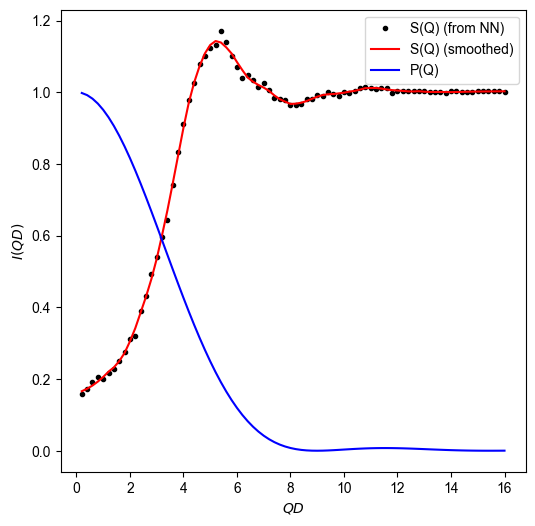

In [115]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q,SQ_th(SQ_NN,fp_opt_NN),'.k', label='S(Q) (from NN)')
SQ_th_sm = savgol_filter(SQ_th(SQ_NN,fp_opt_NN), 11,2)
ax.plot(q,SQ_th_sm,'-r', label='S(Q) (smoothed)')

ax.plot(q,hardsphere(q),'-b', label='P(Q)')

ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')

ax.legend()

# ax.set_yscale('log')
plt.show()

## Result potential parameters

In [107]:
dataname = str(W)
datapath = './results/'

## Result fitting parameters

In [108]:
def Z(A,kappa):
    return np.sqrt(A*(1+1/2/kappa)**2)  

def Z_err(A,kappa,A_err,kappa_err,delta = 1e-3):
    dZ_dA = (Z(A*(1+delta),kappa)-Z(A,kappa))/(A*delta)
    dZ_dkappa = (Z(A,kappa*(1+delta))-Z(A,kappa))/(kappa*delta)
    
    Z_err = np.sqrt((dZ_dA*A_err)**2 + (dZ_dkappa*kappa_err)**2)
    return Z_err

epsilon_0 = 8.854e-12 # Vacuum_permittivity (F*m^-1 = Columb^2 J^-1)
epsilon_water = 80.4*epsilon_0 #  Water permittivity @ 20 degree C
e = 1.60217663e-19 # Electron charge (Columb)
kB = 1.380649e-23 # Boltzmann constant (J/K)


In [109]:
# fitting parameters
fp = fp_opt_NN
fp_err = fp_err_NN
Z_0 = np.sqrt(kB*293*(d_HS_i*1e-9)*epsilon_water/e**2)
fp_Z = Z(fp[2],fp[1])*Z_0
fp_Z_err = Z_err(fp[2],fp[1],fp_err[2],fp_err[1])*Z_0

print('phi =     {:0.4f} +- {:0.4f}'.format(fp[0],fp_err[0]))
print('kappa =   {:0.4f} +- {:0.4f}'.format(fp[1],fp_err[1]))
print('A =       {:0.4f} +- {:0.4f}'.format(fp[2],fp_err[2]))
print('Z =       {:0.4f} +- {:0.4f}'.format(fp_Z,fp_Z_err))

phi =     0.1374 +- 0.0079
kappa =   0.2335 +- 0.0591
A =       1.4953 +- 0.0367
Z =       44.4481 +- 7.6853


In [110]:
with open(datapath+'fp_' + dataname + '.txt', 'w') as f:
    f.write('phi =     {:0.4f} +- {:0.4f}\n'.format(fp[0],fp_err[0]))
    f.write('kappa =   {:0.4f} +- {:0.4f}\n'.format(fp[1],fp_err[1]))
    f.write('A =       {:0.4f} +- {:0.4f}\n'.format(fp[2],fp_err[2]))
    f.write('Z =       {:0.4f} +- {:0.4f}\n'.format(fp_Z,fp_Z_err))
    f.write('d_HS =    {:0.4f}(A)\n'.format(d_HS_i))
    # f.write('C =       {:0.4f} +- {:0.4f} (1/cm)\n'.format(fp[4],fp_err[4]))
    # f.write('I_inc =   {:0.4f} +- {:0.4f} (1/cm)\n'.format(fp[5],fp_err[5]))
    # f.write('R_1 =     {:0.4f} +- {:0.4f} (A)\n'.format(fp[6]*d_HS,fp_err[6]*d_HS))
    # f.write('R_2 =     {:0.4f} +- {:0.4f} (A)\n'.format(fp[7]*d_HS,fp_err[7]*d_HS))
    # f.write('sigma_1 = {:0.4f} +- {:0.4f} (A)\n'.format(fp[8]*d_HS,fp_err[8]*d_HS))
    # f.write('sigma_2 = {:0.4f} +- {:0.4f} (A)\n'.format(fp[9]*d_HS,fp_err[9]*d_HS))
    # f.write('rc =      {:0.4f} +- {:0.4f}'.format(fp[10],fp_err[10]))

 

# Save S(Q) curve

In [111]:
qs = q/d_HS_i
f_interp = interp.interp1d(qs, SQ_th_sm, fill_value='extrapolate')
SQ_extracted = f_interp(Q_1)

from scipy.io import savemat
mdic = {'fp':fp, 'fp_err':fp_err, 'd_HS':d_HS_i,
       'SQ':SQ_extracted, 'Q':Q_1}

savemat(datapath+dataname+'.mat', mdic)

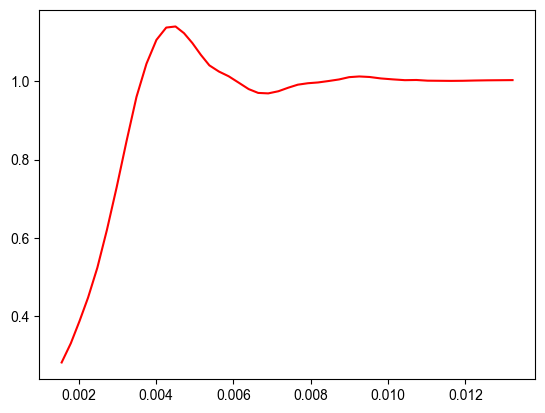

In [112]:
plt.plot(Q_1[Q_1<max(q)/d_HS_i],SQ_extracted[Q_1<max(q)/d_HS_i],'-r')
plt.show()